# Imports

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

from torchvision.models import alexnet
from torchvision import transforms
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import argparse
from torch.utils.data import Dataset, DataLoader

# Pre-Processing

### Generated Data Pre Processing

We first import one training example and check its validity.

In [2]:
filepath = os.getcwd()+"/Data Generation/Data Generated/Dataset PreProcessed/EX_0000.npy"
array = np.load(filepath, allow_pickle=True)

#print(array[0:2])

print(array[0:2])

[['Square Name' 'Image' 'Piece Label']
 ['A1' array([[[115, 122, 121, 255],
               [100, 109, 109, 255],
               [ 87,  98,  98, 255],
               ...,
               [105, 114, 112, 255],
               [111, 119, 118, 255],
               [118, 125, 124, 255]],

              [[100, 109, 108, 255],
               [ 79,  92,  91, 255],
               [ 61,  78,  76, 255],
               ...,
               [ 85,  97,  96, 255],
               [104, 113, 111, 255],
               [121, 127, 126, 255]],

              [[ 86,  98,  96, 255],
               [ 60,  77,  75, 255],
               [ 39,  59,  58, 255],
               ...,
               [ 68,  83,  81, 255],
               [ 94, 105, 103, 255],
               [119, 126, 124, 255]],

              ...,

              [[ 65,  71,  71, 255],
               [ 45,  53,  52, 255],
               [ 34,  42,  42, 255],
               ...,
               [ 87,  99,  97, 255],
               [109, 117, 116, 255],
    

In [3]:
print(array[1][1].shape)
print(array[1:, 1].shape)

(130, 130, 4)
(64,)


We will gather all the training examples stored in "Data Generated/ Dataset PreProcessed" and pre process them even further. Each training example after importation is an array consistsing of three elements: the square name (e.g., A1, C3), the image of the square, and the label of the piece placed on the square (if any). The label has a predefined encoding scheme which is the following:
- Empty: 0
- White pawn: 1
- White knight: 2
- White bishop: 3
- White rook: 4
- White queen: 5
- White king: 6
- Black pawn: 7 
- Black knight: 8
- Black bishop: 9
- Black rook: 10
- Black queen: 11
- Black king: 12

Since the square name column is not used in our model, we can discard it from each training example. We can separate the image data and label information by storing them in separate arrays, denoted by 'X' and 'y', respectively.

In [4]:
# Create X and y
X = np.empty((0))
y = np.empty((0))

# Load data in X and y resepctively 
for i in range(4501):
    filepath = os.getcwd()+"/Data Generation/Data Generated/Dataset PreProcessed/EX_%04d" % i + ".npy"
    t_ex = np.load(filepath, allow_pickle=True) # Load data
    
    X = np.append(X, t_ex[1:, 1]) # Append data to X
    y = np.append(y, t_ex[1:, 2]) # Append label to y

    

Check the shape of X and y and plot the first image with its label as a verification step.

(288064,)
(130, 130, 4)
(288064,)


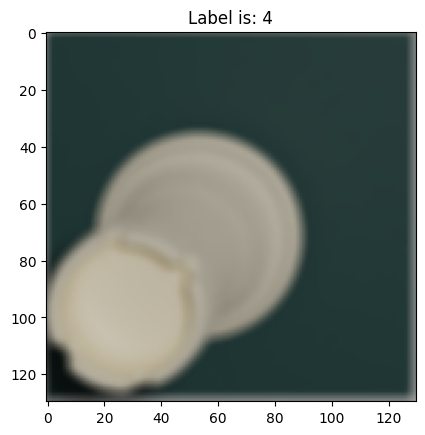

In [5]:
print(X.shape)
print(X[0].shape)
print(y.shape)
# Plot the image
plt.imshow(X[0])
plt.title("Label is: "+str(y[0]))
plt.show()

We will now plot the data distribution and get the mean and standard deviation of the data. We expect a lot of the data to be empty squares with label '0'

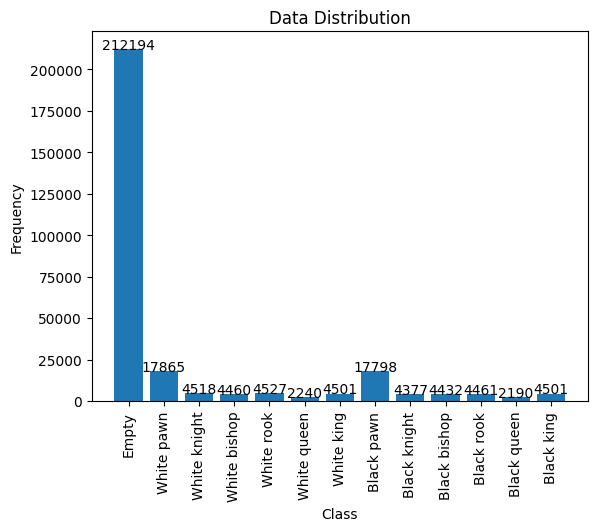

In [6]:
# create a dictionary that maps class numbers to their names
class_names = {0: 'Empty', 1: 'White pawn', 2: 'White knight', 3: 'White bishop', 4: 'White rook',
               5: 'White queen', 6: 'White king', 7: 'Black pawn', 8: 'Black knight', 9: 'Black bishop',
               10: 'Black rook', 11: 'Black queen', 12: 'Black king'}

# create a histogram of the y label
hist, bins, _ = plt.hist(y, bins=range(14), align='left', rwidth=0.8)

# set the x ticks to the class names
plt.xticks(list(class_names.keys()), list(class_names.values()), rotation='vertical')

# add axis labels and title
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Data Distribution')

# add count number above each bar
for i in range(len(class_names)):
    plt.text(i, (hist[i])+5, str(int(hist[i])), ha='center')

# show the plot
plt.show()

As expected, we notice there are a lot of empty squares in the dataset. We now compute the mean and standard deviation values for each R,G,B channel.

In [7]:
# Calculate the mean and standard deviation for each channel
mean_values = np.mean(X, axis=0)
std_values = np.std(X, axis=0)

# Print the results
print('Mean values for each channel (R, G, B): ', mean_values)
print('Standard deviation values for each channel (R, G, B): ', std_values)

: 

: 

Define the dataloaders: we need both a source and a target dataloader.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)
        
        sample = {'image': img, 'label': label}
        return sample


In [ ]:
def get_dataLoader(dataset, batch_size, train=True):
    if dataset == "source":
        # Define the transforms to apply
        transform = transforms.Compose([
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # normalize the image
        ])

        # Create the dataset and dataloader
        images = ...  # numpy array of images
        labels = ...  # numpy array of labels
        dataset = CustomDataset(images, labels, transform=transform)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    if dataset == "target":
         # Define the transforms to apply
        transform = transforms.Compose([
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # normalize the image
        ])

        # Create the dataset and dataloader
        images = ...  # numpy array of images
        labels = ...  # numpy array of labels
        dataset = CustomDataset(images, labels, transform=transform)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Model Implementation

In [ ]:
# The compute_covariance function takes an input data tensor 
# and returns its covariance matrix. 
# The formula for the covariance matrix is given by
# c = (X^T*X - (1/n)*1*(1^T*X)*(1^T*X)^T)/(n-1), 
# where X is the input data tensor. 
# This function first calculates the mean of the columns of the input
#  data tensor, and then uses it to calculate the covariance matrix.
 
def compute_covariance(input_data):
    """
    Compute Covariance matrix of the input data
    """
    # first calculates the batch size n of the input data.
    n = input_data.size(0)  # batch_size

    # Check if using gpu or cpu
    # assigns the appropriate device accordingly
    if input_data.is_cuda:
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    # Create a tensor of size (1, n) with all elements equal to 1, and moves it to the device.
    id_row = torch.ones(n).resize(1, n).to(device=device)

    # calculate the sum of columns of the input data
    # and divide it by n to get the mean of columns mean_column
    # (1/n)*(1^T*X)
    mean = torch.div(torch.mm(id_row, input_data), n)

    # tensor which is the multiplication of the mean of columns with its transpose
    # (1/n)*(1^T*X)*(1^T*X)^T
    term_mul_2 = torch.mm(mean.t(), mean)

    # Calculate the matrix product of the transpose of input data tensor with itself.
    # X^T*X
    XTX = torch.mm(input_data.t(), input_data)

    # Calculate the covariance matrix c
    # c = (X^T*X - (1/n)*(1^T*X)*(1^T*X)^T)/(n-1)
    c = torch.add(XTX, (-1 * term_mul_2)) * 1 / (n - 1)

    # Return the covariance matrix
    return c

# The coral function takes two input data tensors,
#  source and target, and returns the CORAL loss.
#  The CORAL loss is given by
#  loss = sum((c_s - c_t)^2)/(4*d^2),
#  where c_s and c_t are the covariance matrices of the source and target data respectively,
#  and d is the dimension of the input data.
def coral(source, target):

    # first calculates the dimension of the input data d
    d = source.size(1)  # dim vector

    # Calculate the covariance matrices of the source and target data
    source_c = compute_covariance(source)
    target_c = compute_covariance(target)

    # Calculate the CORAL loss
    # loss = sum((c_s - c_t)^2)
    loss = torch.sum(torch.mul((source_c - target_c), (source_c - target_c)))

    # loss = sum((c_s - c_t)^2)/(4*d^2)
    loss = loss / (4 * d * d)
    # Return the CORAL loss
    return loss




In [ ]:
from data_loader import get_loader
from utils import accuracy, Tracker

def train(model, optimizer, source_loader, target_loader, tracker, args, epoch=0):

    model.train()
    tracker_class, tracker_params = tracker.MovingMeanMonitor, {'momentum': 0.99}

    # Trackers to monitor classification and CORAL loss
    classification_loss_tracker = tracker.track('classification_loss', tracker_class(**tracker_params))
    coral_loss_tracker = tracker.track('CORAL_loss', tracker_class(**tracker_params))

    min_n_batches = min(len(source_loader), len(target_loader))

    tq = tqdm(range(min_n_batches), desc='{} E{:03d}'.format('Training + Adaptation', epoch), ncols=0)

    for _ in tq:

        source_data, source_label = next(iter(source_loader))
        target_data, _ = next(iter(target_loader))  # Unsupervised Domain Adaptation

        source_data, source_label = Variable(source_data.to(device=args.device)), Variable(source_label.to(device=args.device))
        target_data = Variable(target_data.to(device=args.device))

        optimizer.zero_grad()

        out_source = model(source_data)
        out_target = model(target_data)

        classification_loss = F.cross_entropy(out_source, source_label)

        # This is where the magic happens
        coral_loss = coral(out_source, out_target)
        composite_loss = classification_loss + args.lambda_coral * coral_loss

        composite_loss.backward()
        optimizer.step()

        classification_loss_tracker.append(classification_loss.item())
        coral_loss_tracker.append(coral_loss.item())
        fmt = '{:.4f}'.format
        tq.set_postfix(classification_loss=fmt(classification_loss_tracker.mean.value),
                       coral_loss=fmt(coral_loss_tracker.mean.value))


def evaluate(model, data_loader, dataset_name, tracker, args, epoch=0):
    model.eval()

    tracker_class, tracker_params = tracker.MeanMonitor, {}
    acc_tracker = tracker.track('{}_accuracy'.format(dataset_name), tracker_class(**tracker_params))

    loader = tqdm(data_loader, desc='{} E{:03d}'.format('Evaluating on %s' % dataset_name, epoch), ncols=0)

    accuracies = []
    with torch.no_grad():
        for target_data, target_label in loader:
            target_data = Variable(target_data.to(device=args.device))
            target_label = Variable(target_label.to(device=args.device))

            output = model(target_data)

            accuracies.append(accuracy(output, target_label))

            acc_tracker.append(sum(accuracies)/len(accuracies))
            fmt = '{:.4f}'.format
            loader.set_postfix(accuracy=fmt(acc_tracker.mean.value))


def main():

    # Paper: In the training phase, we set the batch size to 128,
    # base learning rate to 10−3, weight decay to 5×10−4, and momentum to 0.9

    parser = argparse.ArgumentParser(description='Train - Evaluate DeepCORAL model')
    parser.add_argument('--disable_cuda', action='store_true',
                        help='Disable CUDA')
    parser.add_argument('--epochs', type=int, default=50,
                        help='Number of total epochs to run')
    parser.add_argument('--batch_size', type=int, default=128,
                        help='Batch size')
    parser.add_argument('--lr', default=1e-3,
                        help='Learning Rate')
    parser.add_argument('--decay', default=5e-4,
                        help='Decay of the learning rate')
    parser.add_argument('--momentum', default=0.9,
                        help="Optimizer's momentum")
    parser.add_argument('--lambda_coral', type=float, default=0.5,
                        help="Weight that trades off the adaptation with "
                             "classification accuracy on the source domain")
    parser.add_argument('--source', default='amazon',
                        help="Source Domain (dataset)")
    parser.add_argument('--target', default='webcam',
                        help="Target Domain (dataset)")

    args = parser.parse_args()
    args.device = None

    if not args.disable_cuda and torch.cuda.is_available():
        args.device = torch.device('cuda')
    else:
        args.device = torch.device('cpu')

    source_train_loader = get_loader(name_dataset=args.source, batch_size=args.batch_size, train=True)
    target_train_loader = get_loader(name_dataset=args.target, batch_size=args.batch_size, train=True)

    source_evaluate_loader = get_loader(name_dataset=args.source, batch_size=args.batch_size, train=False)
    target_evaluate_loader = get_loader(name_dataset=args.target, batch_size=args.batch_size, train=False)

    n_classes = len(source_train_loader.dataset.classes)

    # ~ Paper : "We initialized the other layers with the parameters pre-trained on ImageNet"
    # check https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py
    model = alexnet(pretrained=True)
    # ~ Paper : The dimension of last fully connected layer (fc8) was set to the number of categories (31)
    model.classifier[6] = nn.Linear(4096, n_classes)
    # ~ Paper : and initialized with N(0, 0.005)
    torch.nn.init.normal_(model.classifier[6].weight, mean=0, std=5e-3)

    # Initialize bias to small constant number (http://cs231n.github.io/neural-networks-2/#init)
    model.classifier[6].bias.data.fill_(0.01)

    model = model.to(device=args.device)

    # ~ Paper : "The learning rate of fc8 is set to 10 times the other layers as it was training from scratch."
    optimizer = torch.optim.SGD([
        {'params':  model.features.parameters()},
        {'params': model.classifier[:6].parameters()},
        # fc8 -> 7th element (index 6) in the Sequential block
        {'params': model.classifier[6].parameters(), 'lr': 10 * args.lr}
    ], lr=args.lr, momentum=args.momentum)  # if not specified, the default lr is used

    tracker = Tracker()

    for i in range(args.epochs):
        train(model, optimizer, source_train_loader, target_train_loader, tracker, args, i)
        evaluate(model, source_evaluate_loader, 'source', tracker, args, i)
        evaluate(model, target_evaluate_loader, 'target', tracker, args, i)

    # Save logged classification loss, coral loss, source accuracy, target accuracy
    torch.save(tracker.to_dict(), "log.pth")


if __name__ == '__main__':
    main()